# Credit Default Modeling (Utility-Focused, Multi-Seed)
Utility-based comparison of Logistic Regression, Decision Tree, SVM (RBF), Gaussian Naive Bayes, and k-NN on the UCI credit card default data.

## 1. Imports
Load analysis, modeling, and plotting libraries. `xlrd` is pulled in for the Excel source file.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    roc_curve,
    confusion_matrix,
)

sns.set_theme(style="whitegrid")
pd.set_option("display.max_columns", 40)


## 2. Load the data
Read the Excel file, rename the target column to `TARGET`, and preview the dataset.

In [2]:
DATA_FILE = Path("default of credit card clients.xls")
if not DATA_FILE.exists():
    DATA_FILE = Path("Code") / "Final Project" / "default of credit card clients.xls"

if not DATA_FILE.exists():
    raise FileNotFoundError(f"Could not find data file at {DATA_FILE}")

raw_df = (
    pd.read_excel(DATA_FILE, header=1)
    .rename(columns={"default payment next month": "TARGET"})
)

print(f"Loaded {raw_df.shape[0]:,} rows and {raw_df.shape[1]} columns.")
raw_df.head()


Loaded 30,000 rows and 25 columns.


,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,TARGET
0,1,20000,2,2,1,24,2,2,-1,-1,-2,-2,3913,3102,689,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,0,2,2682,1725,2682,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,0,0,29239,14027,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,0,0,46990,48233,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,0,0,8617,5670,35835,20940,19146,19131,2000,36681,10000,9000,689,679,0


## 3. Split features and target
Separate predictors (`X`) from the binary target (`y`).

In [3]:
X = raw_df.drop(columns="TARGET")
y = raw_df["TARGET"].astype(int)

print(f"Feature matrix shape: {X.shape}")
print(f"Target breakdown: {y.value_counts().to_dict()}")
display(X.head(), y.head())


Feature matrix shape: (30000, 24)
Target breakdown: {0: 23364, 1: 6636}


,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
0,1,20000,2,2,1,24,2,2,-1,-1,-2,-2,3913,3102,689,0,0,0,0,689,0,0,0,0
1,2,120000,2,2,2,26,-1,2,0,0,0,2,2682,1725,2682,3272,3455,3261,0,1000,1000,1000,0,2000
2,3,90000,2,2,2,34,0,0,0,0,0,0,29239,14027,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000
3,4,50000,2,2,1,37,0,0,0,0,0,0,46990,48233,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000
4,5,50000,1,2,1,57,-1,0,-1,0,0,0,8617,5670,35835,20940,19146,19131,2000,36681,10000,9000,689,679


0    1
1    1
2    0
3    0
4    0
Name: TARGET, dtype: int64

## 4. Reusable splits and scalers (shared across seeds)
Build consistent train/validation/test splits for each seed and fit a scaler per seed. All models reuse these splits to stay comparable across seeds.

In [4]:
SEED_PLAN = [2025, 0, 1033]
VAL_SEED = 0
BASELINE_SEED = SEED_PLAN[0]


def build_split_bundle(split_seed, val_seed=VAL_SEED):
    X_train, X_test, y_train, y_test = train_test_split(
        X,
        y,
        test_size=0.2,
        random_state=split_seed,
        stratify=y,
    )

    X_train_sub, X_val, y_train_sub, y_val = train_test_split(
        X_train,
        y_train,
        test_size=0.25,
        random_state=val_seed,
        stratify=y_train,
    )

    scaler = StandardScaler()
    scaler.fit(X_train_sub)

    return {
        "seed": split_seed,
        "X_train_sub": X_train_sub,
        "X_val": X_val,
        "X_test": X_test,
        "y_train_sub": y_train_sub,
        "y_val": y_val,
        "y_test": y_test,
        "scaler": scaler,
        "X_train_sub_scaled": scaler.transform(X_train_sub),
        "X_val_scaled": scaler.transform(X_val),
        "X_test_scaled": scaler.transform(X_test),
    }


split_store = {s: build_split_bundle(s, val_seed=VAL_SEED) for s in SEED_PLAN}
baseline_split = split_store[BASELINE_SEED]

display(
    {
        "seed": BASELINE_SEED,
        "train_sub": baseline_split["X_train_sub"].shape,
        "val": baseline_split["X_val"].shape,
        "test": baseline_split["X_test"].shape,
    }
)


{'seed': 2025, 'train_sub': (18000, 24), 'val': (6000, 24), 'test': (6000, 24)}

## 5. Business assumptions and cost matrix
Derive monetary gains/losses from the PDF assumptions to evaluate models on profit rather than accuracy alone.

### 5.1 Observation window and APR assumptions
Compute profit from approving a good customer and loss from approving a bad customer over a six-month window.

In [5]:
df_default = raw_df[raw_df["TARGET"] == 1]   # will default
df_no_default = raw_df[raw_df["TARGET"] == 0]  # will not default

mean_limit_default = df_default["LIMIT_BAL"].mean()
mean_limit_no_default = df_no_default["LIMIT_BAL"].mean()

assumption_config = {
    "annual_apr": 0.18,           # 18% annual percentage rate from the data dictionary PDF
    "periods_per_year": 12,       # monthly compounding
    "observation_months": 6,      # six billing cycles (Apr-Sep 2005 in the PDF)
    "loss_given_default": 0.5,    # lose 50% of the limit if they default
}

annual_apr = assumption_config["annual_apr"]
periods_per_year = assumption_config["periods_per_year"]
observation_months = assumption_config["observation_months"]
loss_given_default = assumption_config["loss_given_default"]

periodic_rate = annual_apr / periods_per_year
period_length_months = 12 / periods_per_year
periods_in_window = observation_months / period_length_months

profit_good = mean_limit_no_default * ((1 + periodic_rate) ** periods_in_window - 1)
loss_bad = mean_limit_default * loss_given_default

print(f"Periodic rate: {periodic_rate:.2%}")
print(f"Approx profit per good customer: {profit_good:,.2f}")
print(f"Approx loss per bad customer:    {loss_bad:,.2f}")


Periodic rate: 1.50%
Approx profit per good customer: 16,642.22
Approx loss per bad customer:    65,054.83


### 5.2 Cost/benefit matrix
Map actual/predicted outcomes to dollar values for the utility function.

In [6]:
value_TN = profit_good    # Actual 0, Pred 0: good customer, approved -> earn interest
value_FP = 0.0              # Actual 0, Pred 1: good customer, rejected -> forego profit
value_FN = -loss_bad        # Actual 1, Pred 0: bad customer, approved -> lose money
value_TP = 0.0              # Actual 1, Pred 1: bad customer, rejected -> avoided loss

value_matrix = pd.DataFrame(
    {
        0: {0: value_TN, 1: value_FN},  # Predicted 0
        1: {0: value_FP, 1: value_TP},  # Predicted 1
    }
)
value_matrix.index.name = "Actual"
value_matrix.columns.name = "Predicted"
value_matrix


Predicted,0,1
Actual,,
0,16642.219712,0.0
1,-65054.828210,0.0


## 6. Utility and evaluation helpers
Shared helpers for threshold sweeps, utility calculation, and concise metric summaries.

In [7]:
CV_FOLDS = 5

THRESH_QUANTILES = np.linspace(0.05, 0.95, 19)

def score_predictions(model, features):
    if hasattr(model, "predict_proba"):
        return model.predict_proba(features)[:, 1]
    if hasattr(model, "decision_function"):
        return model.decision_function(features)
    return model.predict(features)

def utility_from_predictions(y_true, y_pred, values=value_matrix):
    cm = confusion_matrix(y_true, y_pred, labels=[0, 1])
    tn, fp, fn, tp = cm.ravel()
    utility_total = (
        tn * values.loc[0, 0]
        + fp * values.loc[0, 1]
        + fn * values.loc[1, 0]
        + tp * values.loc[1, 1]
    )
    utility_per_case = utility_total / len(y_true)
    return utility_total, utility_per_case, {"tn": tn, "fp": fp, "fn": fn, "tp": tp}

def _utility(y_true, y_pred):
    return utility_from_predictions(y_true, y_pred, value_matrix)

def sweep_thresholds(y_true, scores, utility_fn, grid=None):
    grid = np.unique(np.quantile(scores, THRESH_QUANTILES)) if grid is None else grid
    records = []
    for t in grid:
        preds = (scores >= t).astype(int)
        utility_total, utility_pc, _ = utility_fn(y_true, preds)
        records.append(
            {
                "threshold": float(t),
                "utility": utility_total,
                "utility_per_case": utility_pc,
            }
        )
    best = max(records, key=lambda r: r["utility"])
    return {
        "threshold": best["threshold"],
        "val_utility": best["utility"],
        "val_utility_per_case": best["utility_per_case"],
        "sweep": pd.DataFrame(records),
    }

def summarize_model(
    model_name,
    dataset_name,
    y_true,
    y_pred,
    y_score,
    threshold,
    seed,
    utility_fn=_utility,
):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred, labels=[0, 1]).ravel()
    utility_total, utility_pc, _ = utility_fn(y_true, y_pred)
    roc_auc = roc_auc_score(y_true, y_score) if y_score is not None else np.nan

    total = len(y_pred)
    acceptance_rate = (tn + fn) / total  # predicted 0 = approved
    rejection_rate = (fp + tp) / total   # predicted 1 = rejected

    return pd.DataFrame(
        [
            {
                "model_name": model_name,
                "dataset_name": dataset_name,
                "seed": seed,
                "threshold": threshold,
                "roc_auc": roc_auc,
                "accuracy": accuracy_score(y_true, y_pred),
                "precision": precision_score(y_true, y_pred, zero_division=0),
                "recall": recall_score(y_true, y_pred, zero_division=0),
                "f1": f1_score(y_true, y_pred, zero_division=0),
                "utility_total": utility_total,
                "utility_per_case": utility_pc,
                "acceptance_rate": acceptance_rate,
                "rejection_rate": rejection_rate,
                "tp": tp,
                "fp": fp,
                "tn": tn,
                "fn": fn,
            }
        ]
    )

def run_model_for_seed(
    model,
    model_name,
    split_seed,
    use_scaled=True,
    threshold_grid=None,
):
    split = split_store[split_seed]
    suffix = "_scaled" if use_scaled else ""
    X_train = split[f"X_train_sub{suffix}"]
    X_val = split[f"X_val{suffix}"]
    X_test = split[f"X_test{suffix}"]
    y_train = split["y_train_sub"]
    y_val = split["y_val"]
    y_test = split["y_test"]

    model.fit(X_train, y_train)

    val_scores = score_predictions(model, X_val)
    sweep = sweep_thresholds(y_val, val_scores, _utility, grid=threshold_grid)

    test_scores = score_predictions(model, X_test)
    test_pred = (test_scores >= sweep["threshold"]).astype(int)

    summary = summarize_model(
        model_name=model_name,
        dataset_name=f"Test (seed={split_seed})",
        y_true=y_test,
        y_pred=test_pred,
        y_score=test_scores,
        threshold=sweep["threshold"],
        seed=split_seed,
    )

    return {
        "seed": split_seed,
        "model_name": model_name,
        "model": model,
        "threshold": sweep["threshold"],
        "val_sweep": sweep["sweep"],
        "val_utility": sweep["val_utility"],
        "summary": summary,
        "test_scores": test_scores,
        "test_pred": test_pred,
    }


## 7. Models trained across seeds
Train each model on the shared splits, tune thresholds on the validation fold, and evaluate on the test fold for all seeds.

### 7.1 Logistic Regression

In [8]:
# Logistic Regression helper with CV grid on C for generalization

def run_logreg_for_seed(
    split_seed,
    C_grid=(0.01, 0.1, 1.0, 10.0),
    threshold_grid=None,
    cv_folds=CV_FOLDS,
):
    split = split_store[split_seed]
    X_train = split['X_train_sub_scaled']
    y_train = split['y_train_sub']

    cv = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=split_seed)
    cv_rows = []
    best_mean = -float('inf')
    best_C = None

    for C in C_grid:
        model = LogisticRegression(
            penalty='l2',
            solver='liblinear',
            max_iter=500,
            random_state=split_seed,
            class_weight='balanced',
            C=C,
        )
        scores = cross_val_score(
            model,
            X_train,
            y_train,
            cv=cv,
            scoring='roc_auc',
            n_jobs=-1,
        )
        cv_mean = float(scores.mean())
        cv_std = float(scores.std())
        cv_rows.append({'C': C, 'cv_mean_auc': cv_mean, 'cv_std_auc': cv_std})
        if cv_mean > best_mean:
            best_mean = cv_mean
            best_C = C

    best_model = LogisticRegression(
        penalty='l2',
        solver='liblinear',
        max_iter=500,
        random_state=split_seed,
        class_weight='balanced',
        C=best_C,
    )

    result = run_model_for_seed(
        best_model,
        model_name='Logistic Regression',
        split_seed=split_seed,
        use_scaled=True,
        threshold_grid=threshold_grid,
    )
    result['cv_results'] = pd.DataFrame(cv_rows)
    result['cv_best_params'] = {'C': best_C, 'cv_mean_auc': best_mean}
    return result


In [9]:
logreg_runs = [run_logreg_for_seed(s) for s in SEED_PLAN]

logreg_summary_df = pd.concat([r['summary'] for r in logreg_runs], ignore_index=True)
logreg_summary_df


,model_name,dataset_name,seed,threshold,roc_auc,accuracy,precision,recall,f1,utility_total,utility_per_case,acceptance_rate,rejection_rate,tp,fp,tn,fn
0,Logistic Regression,Test (seed=2025),2025,0.546590,0.722885,0.757167,0.458546,0.541824,0.496718,2.408651e+07,4014.418771,0.738667,0.261333,719,849,3824,608
1,Logistic Regression,Test (seed=0),0,0.547748,0.714051,0.767000,0.476126,0.533534,0.503198,2.453586e+07,4089.310816,0.752167,0.247833,708,779,3894,619
2,Logistic Regression,Test (seed=1033),1033,0.510849,0.714182,0.701667,0.387457,0.600603,0.471040,2.232084e+07,3720.139487,0.657167,0.342833,797,1260,3413,530


### 7.2 Decision Tree

In [10]:
# Decision Tree helper with CV grid on depth and min_samples_leaf

def run_dt_for_seed(
    split_seed,
    max_depth_grid=(None, 6, 10, 14),
    min_samples_leaf_grid=(5, 10, 20),
    threshold_grid=None,
    cv_folds=CV_FOLDS,
):
    split = split_store[split_seed]
    X_train = split['X_train_sub']
    y_train = split['y_train_sub']

    cv = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=split_seed)
    cv_rows = []
    best_mean = -float('inf')
    best_params = None

    for depth in max_depth_grid:
        for min_leaf in min_samples_leaf_grid:
            model = DecisionTreeClassifier(
                random_state=split_seed,
                max_depth=depth,
                min_samples_leaf=min_leaf,
                class_weight='balanced',
            )
            scores = cross_val_score(
                model,
                X_train,
                y_train,
                cv=cv,
                scoring='roc_auc',
                n_jobs=-1,
            )
            cv_mean = float(scores.mean())
            cv_std = float(scores.std())
            cv_rows.append(
                {
                    'max_depth': depth,
                    'min_samples_leaf': min_leaf,
                    'cv_mean_auc': cv_mean,
                    'cv_std_auc': cv_std,
                }
            )
            if cv_mean > best_mean:
                best_mean = cv_mean
                best_params = {'max_depth': depth, 'min_samples_leaf': min_leaf}

    best_model = DecisionTreeClassifier(
        random_state=split_seed,
        max_depth=best_params['max_depth'],
        min_samples_leaf=best_params['min_samples_leaf'],
        class_weight='balanced',
    )
    result = run_model_for_seed(
        best_model,
        model_name='Decision Tree',
        split_seed=split_seed,
        use_scaled=False,
        threshold_grid=threshold_grid,
    )
    result['cv_results'] = pd.DataFrame(cv_rows)
    result['cv_best_params'] = {**best_params, 'cv_mean_auc': best_mean}
    return result


In [11]:
dt_runs = [run_dt_for_seed(s) for s in SEED_PLAN]

dt_summary_df = pd.concat([r['summary'] for r in dt_runs], ignore_index=True)
dt_summary_df


,model_name,dataset_name,seed,threshold,roc_auc,accuracy,precision,recall,f1,utility_total,utility_per_case,acceptance_rate,rejection_rate,tp,fp,tn,fn
0,Decision Tree,Test (seed=2025),2025,0.508695,0.744147,0.736667,0.432749,0.613414,0.507481,2.663872e+07,4439.786235,0.686500,0.313500,814,1067,3606,513
1,Decision Tree,Test (seed=0),0,0.467625,0.753210,0.682333,0.379925,0.690279,0.490102,2.615144e+07,4358.573308,0.598167,0.401833,916,1495,3178,411
2,Decision Tree,Test (seed=1033),1033,0.472664,0.749487,0.734667,0.427714,0.590806,0.496203,2.498663e+07,4164.438753,0.694500,0.305500,784,1049,3624,543


### 7.3 SVM (RBF)

In [12]:
# SVM (RBF) helper with CV grid on C and gamma

def run_svm_for_seed(
    split_seed,
    C_grid=(0.5, 1.0, 2.0, 5.0),
    gamma_grid=('scale', 'auto'),
    threshold_grid=None,
    cv_folds=CV_FOLDS,
):
    split = split_store[split_seed]
    X_train = split['X_train_sub_scaled']
    y_train = split['y_train_sub']

    cv = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=split_seed)
    cv_rows = []
    best_mean = -float('inf')
    best_params = None

    for C in C_grid:
        for gamma in gamma_grid:
            model = SVC(
                kernel='rbf',
                C=C,
                gamma=gamma,
                probability=False,
                class_weight='balanced',
                random_state=split_seed,
            )
            scores = cross_val_score(
                model,
                X_train,
                y_train,
                cv=cv,
                scoring='roc_auc',
                n_jobs=-1,
            )
            cv_mean = float(scores.mean())
            cv_std = float(scores.std())
            cv_rows.append(
                {
                    'C': C,
                    'gamma': gamma,
                    'cv_mean_auc': cv_mean,
                    'cv_std_auc': cv_std,
                }
            )
            if cv_mean > best_mean:
                best_mean = cv_mean
                best_params = {'C': C, 'gamma': gamma}

    best_model = SVC(
        kernel='rbf',
        C=best_params['C'],
        gamma=best_params['gamma'],
        probability=False,
        class_weight='balanced',
        random_state=split_seed,
    )
    result = run_model_for_seed(
        best_model,
        model_name='SVM (RBF)',
        split_seed=split_seed,
        use_scaled=True,
        threshold_grid=threshold_grid,
    )
    result['cv_results'] = pd.DataFrame(cv_rows)
    result['cv_best_params'] = {**best_params, 'cv_mean_auc': best_mean}
    return result


In [13]:
svm_runs = [run_svm_for_seed(s) for s in SEED_PLAN]

svm_summary_df = pd.concat([r['summary'] for r in svm_runs], ignore_index=True)
svm_summary_df


,model_name,dataset_name,seed,threshold,roc_auc,accuracy,precision,recall,f1,utility_total,utility_per_case,acceptance_rate,rejection_rate,tp,fp,tn,fn
0,SVM (RBF),Test (seed=2025),2025,-0.345015,0.754564,0.746833,0.447311,0.614167,0.517625,2.770231e+07,4617.050903,0.696333,0.303667,815,1007,3666,512
1,SVM (RBF),Test (seed=0),0,0.057758,0.755656,0.777833,0.497965,0.553127,0.524099,2.687634e+07,4479.389500,0.754333,0.245667,734,740,3933,593
2,SVM (RBF),Test (seed=1033),1033,-0.553250,0.755029,0.722333,0.417196,0.643557,0.506224,2.714399e+07,4523.998476,0.658833,0.341167,854,1193,3480,473


### 7.4 Naive Bayes (Gaussian)

In [14]:
# Naive Bayes helper with CV grid on var_smoothing

def run_nb_for_seed(
    split_seed,
    var_smoothing_grid=(1e-9, 1e-8, 1e-7, 1e-6),
    threshold_grid=None,
    cv_folds=CV_FOLDS,
):
    split = split_store[split_seed]
    X_train = split['X_train_sub_scaled']
    y_train = split['y_train_sub']

    cv = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=split_seed)
    cv_rows = []
    best_mean = -float('inf')
    best_vs = None

    for vs in var_smoothing_grid:
        model = GaussianNB(var_smoothing=vs)
        scores = cross_val_score(
            model,
            X_train,
            y_train,
            cv=cv,
            scoring='roc_auc',
            n_jobs=-1,
        )
        cv_mean = float(scores.mean())
        cv_std = float(scores.std())
        cv_rows.append({'var_smoothing': vs, 'cv_mean_auc': cv_mean, 'cv_std_auc': cv_std})
        if cv_mean > best_mean:
            best_mean = cv_mean
            best_vs = vs

    best_model = GaussianNB(var_smoothing=best_vs)
    result = run_model_for_seed(
        best_model,
        model_name='Naive Bayes',
        split_seed=split_seed,
        use_scaled=True,
        threshold_grid=threshold_grid,
    )
    result['cv_results'] = pd.DataFrame(cv_rows)
    result['cv_best_params'] = {'var_smoothing': best_vs, 'cv_mean_auc': best_mean}
    return result


In [15]:
nb_runs = [run_nb_for_seed(s) for s in SEED_PLAN]

nb_summary_df = pd.concat([r['summary'] for r in nb_runs], ignore_index=True)
nb_summary_df


,model_name,dataset_name,seed,threshold,roc_auc,accuracy,precision,recall,f1,utility_total,utility_per_case,acceptance_rate,rejection_rate,tp,fp,tn,fn
0,Naive Bayes,Test (seed=2025),2025,0.672817,0.729111,0.737667,0.432771,0.599096,0.502528,2.581873e+07,4303.121861,0.693833,0.306167,795,1042,3631,532
1,Naive Bayes,Test (seed=0),0,0.607381,0.717083,0.718667,0.410154,0.620950,0.494005,2.532548e+07,4220.913961,0.665167,0.334833,824,1185,3488,503
2,Naive Bayes,Test (seed=1033),1033,0.659000,0.736167,0.747667,0.446965,0.593821,0.510032,2.647838e+07,4413.062681,0.706167,0.293833,788,975,3698,539


### 7.5 k-NN

In [16]:
# k-NN-specific helper to train/evaluate per seed with CV-selected k

def run_knn_for_seed(
    split_seed,
    k_grid=(5, 10, 15, 20, 25, 30, 35, 40, 45, 50),
    threshold_grid=None,
    cv_folds=CV_FOLDS,
):
    split = split_store[split_seed]
    X_train = split['X_train_sub_scaled']
    X_val = split['X_val_scaled']
    X_test = split['X_test_scaled']
    y_train = split['y_train_sub']
    y_val = split['y_val']
    y_test = split['y_test']

    cv = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=split_seed)
    cv_rows = []
    best_mean = -float('inf')
    best_k = None

    for k in k_grid:
        model = KNeighborsClassifier(n_neighbors=k, weights='distance')
        scores = cross_val_score(
            model,
            X_train,
            y_train,
            cv=cv,
            scoring='roc_auc',
            n_jobs=-1,
        )
        cv_mean = float(scores.mean())
        cv_std = float(scores.std())
        cv_rows.append({'k': k, 'cv_mean_auc': cv_mean, 'cv_std_auc': cv_std})
        if cv_mean > best_mean:
            best_mean = cv_mean
            best_k = k

    best_model = KNeighborsClassifier(n_neighbors=best_k, weights='distance')
    best_model.fit(X_train, y_train)

    val_scores = score_predictions(best_model, X_val)
    sweep = sweep_thresholds(y_val, val_scores, _utility, grid=threshold_grid)

    test_scores = score_predictions(best_model, X_test)
    test_pred = (test_scores >= sweep['threshold']).astype(int)

    summary = summarize_model(
        model_name='k-NN',
        dataset_name=f'Test (seed={split_seed})',
        y_true=y_test,
        y_pred=test_pred,
        y_score=test_scores,
        threshold=sweep['threshold'],
        seed=split_seed,
    )

    return {
        'seed': split_seed,
        'model_name': 'k-NN',
        'model': best_model,
        'k': best_k,
        'threshold': sweep['threshold'],
        'val_sweep': sweep['sweep'],
        'val_utility': sweep['val_utility'],
        'summary': summary,
        'test_scores': test_scores,
        'test_pred': test_pred,
        'cv_results': pd.DataFrame(cv_rows),
        'cv_best_params': {'k': best_k, 'cv_mean_auc': best_mean},
    }


In [17]:
knn_runs = [run_knn_for_seed(s, k_grid=(5,10,15,20,25,30,35,40,45,50)) for s in SEED_PLAN]

knn_summary_df = pd.concat([r['summary'] for r in knn_runs], ignore_index=True)
knn_summary_df


,model_name,dataset_name,seed,threshold,roc_auc,accuracy,precision,recall,f1,utility_total,utility_per_case,acceptance_rate,rejection_rate,tp,fp,tn,fn
0,k-NN,Test (seed=2025),2025,0.219905,0.742380,0.732000,0.424259,0.593067,0.494657,2.486559e+07,4144.265805,0.690833,0.309167,787,1068,3605,540
1,k-NN,Test (seed=0),0,0.216621,0.741847,0.738167,0.431306,0.577242,0.493716,2.446469e+07,4077.448696,0.704000,0.296000,766,1010,3663,561
2,k-NN,Test (seed=1033),1033,0.239929,0.744933,0.771667,0.485384,0.538056,0.510365,2.529232e+07,4215.387116,0.754833,0.245167,714,757,3916,613


In [18]:
model_runs = {
    "Logistic Regression": logreg_runs,
    "Decision Tree": dt_runs,
    "SVM (RBF)": svm_runs,
    "Naive Bayes": nb_runs,
    "k-NN": knn_runs,
}

model_summary_frames = {
    "Logistic Regression": logreg_summary_df,
    "Decision Tree": dt_summary_df,
    "SVM (RBF)": svm_summary_df,
    "Naive Bayes": nb_summary_df,
    "k-NN": knn_summary_df,
}

combined_model_summaries = pd.concat(model_summary_frames.values(), ignore_index=True)
combined_model_summaries


,model_name,dataset_name,seed,threshold,roc_auc,accuracy,precision,recall,f1,utility_total,utility_per_case,acceptance_rate,rejection_rate,tp,fp,tn,fn
0,Logistic Regression,Test (seed=2025),2025,0.546590,0.722885,0.757167,0.458546,0.541824,0.496718,2.408651e+07,4014.418771,0.738667,0.261333,719,849,3824,608
1,Logistic Regression,Test (seed=0),0,0.547748,0.714051,0.767000,0.476126,0.533534,0.503198,2.453586e+07,4089.310816,0.752167,0.247833,708,779,3894,619
2,Logistic Regression,Test (seed=1033),1033,0.510849,0.714182,0.701667,0.387457,0.600603,0.471040,2.232084e+07,3720.139487,0.657167,0.342833,797,1260,3413,530
3,Decision Tree,Test (seed=2025),2025,0.508695,0.744147,0.736667,0.432749,0.613414,0.507481,2.663872e+07,4439.786235,0.686500,0.313500,814,1067,3606,513
4,Decision Tree,Test (seed=0),0,0.467625,0.753210,0.682333,0.379925,0.690279,0.490102,2.615144e+07,4358.573308,0.598167,0.401833,916,1495,3178,411
5,Decision Tree,Test (seed=1033),1033,0.472664,0.749487,0.734667,0.427714,0.590806,0.496203,2.498663e+07,4164.438753,0.694500,0.305500,784,1049,3624,543
6,SVM (RBF),Test (seed=2025),2025,-0.345015,0.754564,0.746833,0.447311,0.614167,0.517625,2.770231e+07,4617.050903,0.696333,0.303667,815,1007,3666,512
7,SVM (RBF),Test (seed=0),0,0.057758,0.755656,0.777833,0.497965,0.553127,0.524099,2.687634e+07,4479.389500,0.754333,0.245667,734,740,3933,593
8,SVM (RBF),Test (seed=1033),1033,-0.553250,0.755029,0.722333,0.417196,0.643557,0.506224,2.714399e+07,4523.998476,0.658833,0.341167,854,1193,3480,473
9,Naive Bayes,Test (seed=2025),2025,0.672817,0.729111,0.737667,0.432771,0.599096,0.502528,2.581873e+07,4303.121861,0.693833,0.306167,795,1042,3631,532


## 8. Summary table (all seeds)
Per-seed metrics for every model plus the three baselines.

In [22]:
baseline_true = baseline_split["y_test"].values

def baseline_summary(name, y_pred):
    return summarize_model(
        model_name=name,
        dataset_name="Test (baseline seed)",
        y_true=baseline_true,
        y_pred=y_pred,
        y_score=None,
        threshold=np.nan,
        seed=np.nan,
    )

rng = np.random.default_rng(0)
baseline_random = baseline_summary("Baseline - Random", rng.integers(0, 2, size=len(baseline_true)))
baseline_approve = baseline_summary("Baseline - Approve all", np.zeros_like(baseline_true))
baseline_reject = baseline_summary("Baseline - Reject all", np.ones_like(baseline_true))

baseline_df = pd.concat([baseline_random, baseline_approve, baseline_reject], ignore_index=True)

summary_table = pd.concat([baseline_df, combined_model_summaries], ignore_index=True)
summary_table


,model_name,dataset_name,seed,threshold,roc_auc,accuracy,precision,recall,f1,utility_total,utility_per_case,acceptance_rate,rejection_rate,tp,fp,tn,fn
0,Baseline - Random,Test (baseline seed),NaN,NaN,NaN,0.492333,0.214167,0.485305,0.297185,-5.988920e+06,-998.153356,0.498833,0.501167,644,2363,2310,683
1,Baseline - Approve all,Test (baseline seed),NaN,NaN,NaN,0.778833,0.000000,0.000000,0.000000,-8.558664e+06,-1426.444054,1.000000,0.000000,0,0,4673,1327
2,Baseline - Reject all,Test (baseline seed),NaN,NaN,NaN,0.221167,0.221167,1.000000,0.362222,0.000000e+00,0.000000,0.000000,1.000000,1327,4673,0,0
3,Logistic Regression,Test (seed=2025),2025.0,0.546590,0.722885,0.757167,0.458546,0.541824,0.496718,2.408651e+07,4014.418771,0.738667,0.261333,719,849,3824,608
4,Logistic Regression,Test (seed=0),0.0,0.547748,0.714051,0.767000,0.476126,0.533534,0.503198,2.453586e+07,4089.310816,0.752167,0.247833,708,779,3894,619
5,Logistic Regression,Test (seed=1033),1033.0,0.510849,0.714182,0.701667,0.387457,0.600603,0.471040,2.232084e+07,3720.139487,0.657167,0.342833,797,1260,3413,530
6,Decision Tree,Test (seed=2025),2025.0,0.508695,0.744147,0.736667,0.432749,0.613414,0.507481,2.663872e+07,4439.786235,0.686500,0.313500,814,1067,3606,513
7,Decision Tree,Test (seed=0),0.0,0.467625,0.753210,0.682333,0.379925,0.690279,0.490102,2.615144e+07,4358.573308,0.598167,0.401833,916,1495,3178,411
8,Decision Tree,Test (seed=1033),1033.0,0.472664,0.749487,0.734667,0.427714,0.590806,0.496203,2.498663e+07,4164.438753,0.694500,0.305500,784,1049,3624,543
9,SVM (RBF),Test (seed=2025),2025.0,-0.345015,0.754564,0.746833,0.447311,0.614167,0.517625,2.770231e+07,4617.050903,0.696333,0.303667,815,1007,3666,512


## 9. Model comparison summary (baselines + averages)
Average the seed-level rows to compare overall performance alongside the baselines.

In [23]:
def average_rows(df, label):
    numeric_cols = [c for c in df.columns if pd.api.types.is_numeric_dtype(df[c])]
    numeric_cols_no_seed = [c for c in numeric_cols if c != "seed"]
    avg_row = df[numeric_cols_no_seed].mean().to_frame().T
    avg_row["model_name"] = f"{label} (avg seeds)"
    avg_row["dataset_name"] = "Test (avg seeds)"
    cols = [c for c in df.columns if c != "seed"]
    return avg_row.reindex(columns=cols)

avg_rows = [
    average_rows(logreg_summary_df, "Logistic Regression"),
    average_rows(dt_summary_df, "Decision Tree"),
    average_rows(svm_summary_df, "SVM (RBF)"),
    average_rows(nb_summary_df, "Naive Bayes"),
    average_rows(knn_summary_df, "k-NN"),
]

comparison_df = pd.concat([baseline_df] + avg_rows, ignore_index=True)
comparison_df


,model_name,dataset_name,seed,threshold,roc_auc,accuracy,precision,recall,f1,utility_total,utility_per_case,acceptance_rate,rejection_rate,tp,fp,tn,fn
0,Baseline - Random,Test (baseline seed),NaN,NaN,NaN,0.492333,0.214167,0.485305,0.297185,-5.988920e+06,-998.153356,0.498833,0.501167,644.000000,2363.000000,2310.000000,683.000000
1,Baseline - Approve all,Test (baseline seed),NaN,NaN,NaN,0.778833,0.000000,0.000000,0.000000,-8.558664e+06,-1426.444054,1.000000,0.000000,0.000000,0.000000,4673.000000,1327.000000
2,Baseline - Reject all,Test (baseline seed),NaN,NaN,NaN,0.221167,0.221167,1.000000,0.362222,0.000000e+00,0.000000,0.000000,1.000000,1327.000000,4673.000000,0.000000,0.000000
3,Logistic Regression (avg seeds),Test (avg seeds),NaN,0.535063,0.717040,0.741944,0.440710,0.558654,0.490319,2.364774e+07,3941.289691,0.716000,0.284000,741.333333,962.666667,3710.333333,585.666667
4,Decision Tree (avg seeds),Test (avg seeds),NaN,0.482995,0.748948,0.717889,0.413463,0.631500,0.497928,2.592560e+07,4320.932765,0.659722,0.340278,838.000000,1203.666667,3469.333333,489.000000
5,SVM (RBF) (avg seeds),Test (avg seeds),NaN,-0.280169,0.755083,0.749000,0.454157,0.603617,0.515982,2.724088e+07,4540.146293,0.703167,0.296833,801.000000,980.000000,3693.000000,526.000000
6,Naive Bayes (avg seeds),Test (avg seeds),NaN,0.646400,0.727453,0.734667,0.429964,0.604622,0.502189,2.587420e+07,4312.366168,0.688389,0.311611,802.333333,1067.333333,3605.666667,524.666667
7,k-NN (avg seeds),Test (avg seeds),NaN,0.225485,0.743053,0.747278,0.446983,0.569455,0.499579,2.487420e+07,4145.700539,0.716556,0.283444,755.666667,945.000000,3728.000000,571.333333


## 10. Multi-model visualizations
Seed-level utility bars, ROC curves (baseline seed), and a confusion matrix for the top average-utility model.

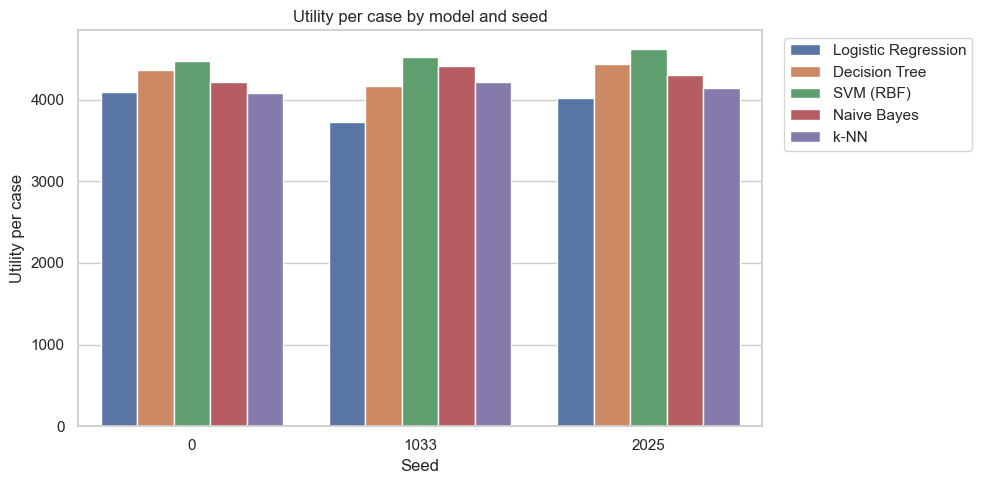

In [19]:
plot_data = combined_model_summaries.copy()
plot_data["seed"] = plot_data["seed"].astype(int)

fig, ax = plt.subplots(figsize=(10, 5))
sns.barplot(data=plot_data, x="seed", y="utility_per_case", hue="model_name", ax=ax)
ax.set_title("Utility per case by model and seed")
ax.set_xlabel("Seed")
ax.set_ylabel("Utility per case")
ax.legend(bbox_to_anchor=(1.02, 1), loc="upper left")
plt.tight_layout()


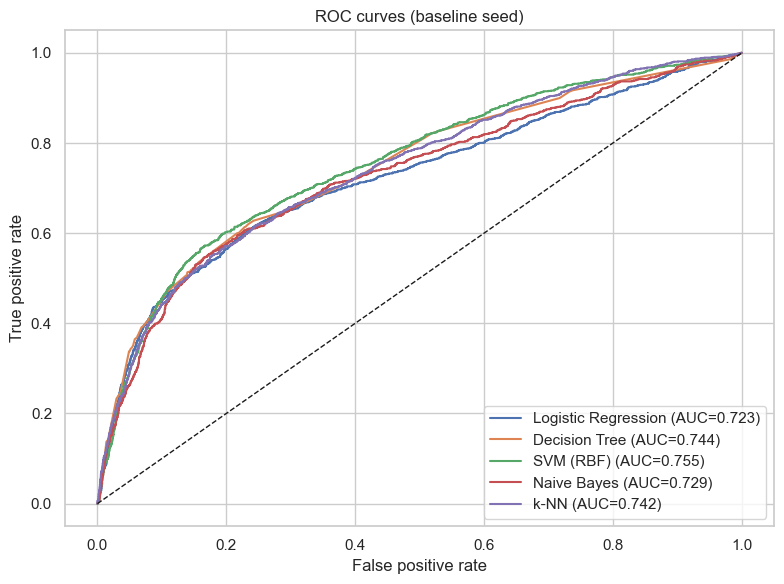

In [20]:
baseline_y_true = baseline_split["y_test"].values

fig, ax = plt.subplots(figsize=(8, 6))
for name, runs in model_runs.items():
    baseline_run = next(r for r in runs if r["seed"] == BASELINE_SEED)
    fpr, tpr, _ = roc_curve(baseline_y_true, baseline_run["test_scores"])
    auc_val = baseline_run["summary"]["roc_auc"].iloc[0]
    ax.plot(fpr, tpr, label=f"{name} (AUC={auc_val:.3f})")

ax.plot([0, 1], [0, 1], "k--", linewidth=1)
ax.set_title("ROC curves (baseline seed)")
ax.set_xlabel("False positive rate")
ax.set_ylabel("True positive rate")
ax.legend(loc="lower right")
plt.tight_layout()


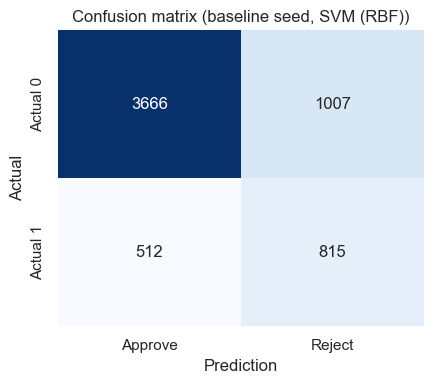

In [21]:
avg_util = combined_model_summaries.groupby("model_name")["utility_per_case"].mean().sort_values(ascending=False)
top_model_name = avg_util.index[0]
top_run = next(r for r in model_runs[top_model_name] if r["seed"] == BASELINE_SEED)

cm = confusion_matrix(baseline_y_true, top_run["test_pred"], labels=[0, 1])
fig, ax = plt.subplots(figsize=(4.5, 4))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    cbar=False,
    ax=ax,
    xticklabels=["Approve", "Reject"],
    yticklabels=["Actual 0", "Actual 1"],
)
ax.set_title(f"Confusion matrix (baseline seed, {top_model_name})")
ax.set_xlabel("Prediction")
ax.set_ylabel("Actual")
plt.tight_layout()
